### Using pre-trained model

Today we're going to build and fine-tune CNN based on weights pre-trained on ImageNet: the largest image classification dataset as of now.
More about imagenet: http://image-net.org/
Setup: classify from a set of 1000 classes.

In [1]:
import requests

# class labels
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
labels = {int(key):value for (key, value) in requests.get(LABELS_URL).json().items()}

In [2]:
print(list(labels.items())[:5])

[(0, 'tench, Tinca tinca'), (1, 'goldfish, Carassius auratus'), (2, 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias'), (3, 'tiger shark, Galeocerdo cuvieri'), (4, 'hammerhead, hammerhead shark')]


### TorchVision
PyTorch has several companion libraries, one of them being [torchvision](https://github.com/pytorch/vision/tree/master/) - it contains a number of popular vision datasets, preprocessing tools and most importantly, [pre-trained models](https://github.com/pytorch/vision/tree/master/torchvision/models).

For now, we're going to use torch Inception-v3 module.

We're gonna use the inception-v3 network:
![img](https://hackathonprojects.files.wordpress.com/2016/09/googlenet_diagram.png?w=650&h=192)

Let's first look at the code here: [url](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py)

In [3]:
from torchvision.models.inception import inception_v3

model = inception_v3(pretrained=True,      # load existing weights
                     transform_input=True, # preprocess input image the same way as in training
                    )

model.aux_logits = False # don't predict intermediate logits (yellow layers at the bottom)
model.train(False)

_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (branch5x5_2): BasicConv2d(
      (conv): Conv2d(48, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (branch3x3dbl_1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (branch3x3dbl_2): BasicConv2d(
      (conv): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(96, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (branch3x3dbl_3): BasicConv2d(
      (conv): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(96, eps=0.001, momentum=0.1, affine=True, track_runni

In [4]:
import torch
from torch.autograd import Variable

dummy_x = Variable(torch.randn(5, 3, 299, 299))
model(dummy_x)

tensor([[-0.9843,  0.9173,  2.0217,  ..., -2.1757, -0.5531,  1.5511],
        [-1.0667,  0.9689,  1.9926,  ..., -2.0344, -0.4148,  1.2514],
        [-1.0352,  1.1945,  1.8514,  ..., -2.3206, -0.3961,  1.4961],
        [-1.0257,  0.9437,  1.9066,  ..., -2.2521, -0.4988,  1.6308],
        [-1.1926,  0.7842,  1.8608,  ..., -2.1066, -0.6266,  1.4093]],
       grad_fn=<AddmmBackward>)

### Predict class probabilities

In [ ]:
# If using Colab
!mkdir sample_images
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/sem4_spring19/week04_finetuning/sample_images/albatross.jpg -O sample_images/albatross.jpg

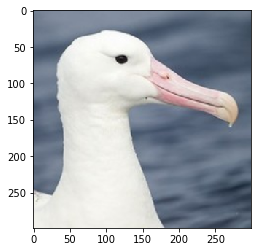

top-10 classes are: 
 [prob : class label]
0.9741 :	albatross
0.0031 :	turnstile
0.0005 :	Shetland sheepdog
0.0005 :	llama
0.0003 :	collie
0.0003 :	drake
0.0003 :	hammerhead
0.0003 :	nipple
0.0003 :	Polaroid camera


In [5]:
import matplotlib.pyplot as plt
from skimage.transform import resize
%matplotlib inline

img = resize(plt.imread('sample_images/albatross.jpg'), (299, 299))
plt.imshow(img)
plt.show()


def predict(img):
    img = Variable(torch.FloatTensor(img.reshape([1, 299, 299, 3]).transpose([0, 3, 1, 2])))
    
    probs = torch.nn.functional.softmax(model(img), dim=-1)
    
    probs = probs.data.numpy()
    
    top_ix = probs.ravel().argsort()[-1:-10:-1]
    print ('top-10 classes are: \n [prob : class label]')
    for l in top_ix:
        print ('%.4f :\t%s' % (probs.ravel()[l], labels[l].split(',')[0]))
        

predict(img)

### Having fun with pre-trained nets

In [ ]:
!wget http://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg -O img.jpg

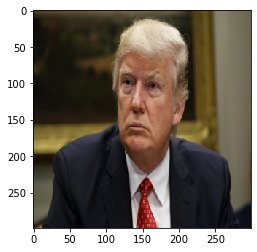

top-10 classes are: 
 [prob : class label]
0.6960 :	suit
0.0915 :	Windsor tie
0.0597 :	groom
0.0045 :	oboe
0.0039 :	academic gown
0.0034 :	Loafer
0.0033 :	wig
0.0028 :	Afghan hound
0.0027 :	bow tie


In [6]:
img = resize(plt.imread('img.jpg'), (299, 299))
plt.imshow(img)
plt.show()

predict(img)

# Grand-quest: Dogs Vs Cats
* original competition
* https://www.kaggle.com/c/dogs-vs-cats
* 25k JPEG images of various size, 2 classes (guess what)

### Your main objective
* In this seminar your goal is to fine-tune a pre-trained model to distinguish between the two rivaling animals
* The first step is to just reuse some network layer as features

In [ ]:
!wget https://www.dropbox.com/s/ae1lq6dsfanse76/dogs_vs_cats.train.zip?dl=1 -O data.zip
!unzip data.zip

### How to get features
During good old days in Torch7 you could access any intermediate output from the sequential model. Nowadays it's a bit more difficult though it's not Tensorflow where you need to compile another model for that. Here we're going to redefine the last layer... yes, to do nothing.

' model.eval()\nmodel.fc = Identity()\nmodel.to(device)\nnew_X_train, new_y_train = [], []\nfor (X_batch, y_batch) in train_batch_gen:\n    with torch.no_grad():\n        new_X_train.extend(model(X_batch.to(device)).detach().cpu().numpy())\n        new_y_train.extend(y_batch.detach().cpu().numpy())\n\nnew_X_train = np.array(new_X_train)\nnew_y_train = np.array(new_y_train)\n\n\nnew_X_test, new_y_test = [], []\nfor (X_batch, y_batch) in val_batch_gen:\n    with torch.no_grad():\n        new_X_test.extend(model(X_batch.to(device)).detach().cpu().numpy())\n        new_y_test.extend(y_batch.detach().cpu().numpy())\n        \nnew_X_test = np.array(new_X_test)\nnew_y_test = np.array(new_y_test) '

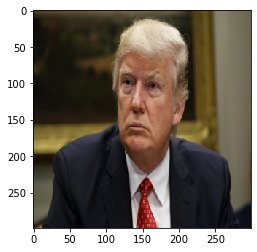

In [7]:
from copy import deepcopy  # in case you still need original model

embedding = deepcopy(model)

class Identity(torch.nn.Module):

    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        #<YOUR CODE>
        return x
        
    
# redefine the last layer to be Identity
#<YOUR CODE>
# Fully Connected Layer - FC.Layer
plt.imshow(img)
#img = resize(plt.imread('sample_images/albatross.jpg'), (299, 299))
img2 = Variable(torch.FloatTensor(img.reshape([1, 299, 299, 3]).transpose([0, 3, 1, 2])))

embedding.fc = Identity()

#print("!")

""" model.eval()
model.fc = Identity()
model.to(device)
new_X_train, new_y_train = [], []
for (X_batch, y_batch) in train_batch_gen:
    with torch.no_grad():
        new_X_train.extend(model(X_batch.to(device)).detach().cpu().numpy())
        new_y_train.extend(y_batch.detach().cpu().numpy())

new_X_train = np.array(new_X_train)
new_y_train = np.array(new_y_train)


new_X_test, new_y_test = [], []
for (X_batch, y_batch) in val_batch_gen:
    with torch.no_grad():
        new_X_test.extend(model(X_batch.to(device)).detach().cpu().numpy())
        new_y_test.extend(y_batch.detach().cpu().numpy())
        
new_X_test = np.array(new_X_test)
new_y_test = np.array(new_y_test) """




In [ ]:
from torchsummary import summary

summary(embedding.cuda(), (3, 299, 299))

In [8]:
print(embedding(img2).data.numpy().shape)

(1, 2048)


In [9]:
assert embedding(img2).data.numpy().shape == (1, 2048), "your output for single image should have shape (1, 2048)"

# for starters
* Train sklearn model, evaluate validation accuracy (should be >80%

In [10]:
#extract features from images
from tqdm import tqdm
import numpy as np
from scipy.misc import imread, imresize
import os

X = []
Y = []

batch_size = 50
imgs = np.zeros([batch_size, 299, 299, 3])
batch_index = 0

for fname in tqdm(os.listdir('train')):
    
    y = fname.startswith("cat")
    Y.append(y)
    
    img = imread(os.path.join("train", fname))
    
    img = imresize(img, (299, 299)) / 255.
    imgs[batch_index] = img
    
    if batch_index == batch_size - 1:
        input_tensor = Variable(torch.FloatTensor(imgs.transpose([0,3,1,2])))
    
        # use your embedding model to produce feature vector
        features = embedding(input_tensor).data.numpy()
        
        X.append(features)
        
        batch_index = 0
        continue
        
    batch_index += 1

100%|██████████| 25000/25000 [1:23:13<00:00,  5.01it/s]


In [11]:
import numpy as np

X = np.concatenate(X) #stack all [1xfeatures] matrices into one. 
assert X.ndim == 2
#WARNING! the concatenate works for [1xN] matrices. If you have other format, stack them yourself.

#crop if we ended prematurely
Y = np.array(Y[:len(X)])

print(X.shape, Y.shape)

(25000, 2048) (25000,)


In [14]:
#<split data here or use cross-validation>
#X_train, X_valid = torch.utils.data.random_split(X[0], [25000, 1000])
#y_train, y_valid = torch.utils.data.random_split(Y, [25000, 1000])



In [17]:
from sklearn.model_selection import train_test_split
#validation
X_train, X_valid, y_train, y_valid = train_test_split(
     X, Y, test_size=0.1)
#test
X_train, X_test, y_train, y_test = train_test_split(
     X_train, y_train, test_size=0.1)

__load our dakka__
![img](https://s-media-cache-ak0.pinimg.com/564x/80/a1/81/80a1817a928744a934a7d32e7c03b242.jpg)

In [18]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [19]:
def accuracy(predicted,true):
    return 100*sum([(p==t) for p,t in zip(predicted,true)])/len(true)

In [20]:
#Random Forest
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)
predict_valid = random_forest.predict(X_valid)
print('validation',accuracy(predict_valid, y_valid))
predict_test = random_forest.predict(X_test)
print('test',accuracy(predict_test,y_test))

validation 97.96
test 98.31111111111112


In [21]:
# Ridge Classifier
ridge_classifier =  RidgeClassifier(alpha = 0.01)
ridge_classifier.fit(X_train, y_train)
predict_valid = ridge_classifier.predict(X_valid)
print('validation',accuracy(predict_valid, y_valid))
predict_test = ridge_classifier.predict(X_test)
print('test',accuracy(predict_test, y_test))

validation 98.68
test 98.66666666666667


In [22]:
# Logistic Regression
logistic_regression =  LogisticRegression()
logistic_regression.fit(X_train,y_train)
predict_valid = logistic_regression.predict(X_valid)
print('validaion',accuracy(predict_valid,y_valid))
predict_test = logistic_regression.predict(X_test)
print('test',accuracy(predict_test,y_test))

validaion 98.64
test 98.53333333333333


In [23]:
# AdaBoostClassifier
ada_boosting_classifier =  AdaBoostClassifier()
ada_boosting_classifier.fit(X_train,y_train)
predict_valid = ada_boosting_classifier.predict(X_valid)
print('validation',accuracy(predict_valid,y_valid))
predict_test = ada_boosting_classifier.predict(X_test)
print('test',accuracy(predict_test,y_test))

validation 97.64
test 97.82222222222222


In [24]:
# SVC
svc =  SVC()
svc.fit(X_train,y_train)
predict_valid = svc.predict(X_valid)
print('validation',accuracy(predict_valid,y_valid))
predict_test = svc.predict(X_test)
print('test',accuracy(predict_test,y_test))

validation 98.72
test 99.02222222222223


In [25]:
# DecisionTreeClassifier
decision_tree_classifier =  DecisionTreeClassifier()
decision_tree_classifier.fit(X_train,y_train)
predict_valid = decision_tree_classifier.predict(X_valid)
print('validation', accuracy(predict_valid,y_valid))
predict_test = decision_tree_classifier.predict(X_test)
print('test',accuracy(predict_test,y_test))

validation 96.0
test 97.02222222222223


In [26]:
grad_boost = GradientBoostingClassifier()
grad_boost.fit(X_train, y_train)
predict_valid = grad_boost.predict(X_valid)
print('validation', accuracy(predict_valid, y_valid))
predict_test = grad_boost.predict(X_test)
print('test', accuracy(predict_test,y_test))

validation 97.84
test 98.22222222222223


# Main quest

* Get the score improved!
* You have to reach __at least 95%__ on the test set. More = better.

No methods are illegal: ensembling, data augmentation, NN hacks. 
Just don't let test data slip into training.


### Split the raw image data
  * please do train/validation/test instead of just train/test
  * reasonable but not optimal split is 20k/2.5k/2.5k or 15k/5k/5k

### Build a few layers on top of chosen "neck" layers.
  * a good idea is to just stack more layers inside the same network
  * alternative: stack on top of get_output

### Train the newly added layers for some iterations
  * you can selectively train some weights by sending the correct parameters in the optimizer
      * `opt = torch.optim.Adam([head_only.parameters()])``
  * it's cruicial to monitor the network performance at this and following steps

### Fine-tune the network body
  * probably a good idea to SAVE your new network weights now 'cuz it's easy to mess things up.
  * Moreover, saving weights periodically is a no-nonsense idea
  * even more cruicial to monitor validation performance
  * main network body may need a separate, much lower learning rate

# Bonus: #deepdream

https://twitter.com/search?q=%23deepdream&src=typd

Code is heavily based on https://github.com/thesemicolonguy/deep-dream-pytorch

Original blogpost where more ideas can be taken from: https://research.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html

In [ ]:
from PIL import Image, ImageFilter, ImageChops
from torchvision import transforms
import numpy as np

In [ ]:
modulelist = list(model.children())

In [ ]:
preprocess = transforms.Compose([
#    transforms.Resize((299, 299)),  # do we really need this now?
    transforms.ToTensor()#,
    ])


def dd_helper(image, layer, iterations, lr):
    input_var = Variable(preprocess(image).unsqueeze(0), requires_grad=True)
    model.zero_grad()
    for i in range(iterations):
        out = input_var
        for j in range(layer):
            out = modulelist[j](out)
        loss = out.norm()
        loss.backward()
        input_var.data = input_var.data + lr * input_var.grad.data
    
    input_im = input_var.data.squeeze()
    input_im.transpose_(0, 1)
    input_im.transpose_(1, 2)
    input_im = np.clip(input_im, 0, 1)
    im = Image.fromarray(np.uint8(input_im * 255))
    return im

In [ ]:
def deep_dream(image, layer, iterations, lr, octave_scale, num_octaves):
    if num_octaves>0:
        image1 = image.filter(ImageFilter.GaussianBlur(2))
        if (image1.size[0] / octave_scale < 1 or image1.size[1] / octave_scale < 1):
            size = image1.size
        else:
            size = (int(image1.size[0] / octave_scale), int(image1.size[1] / octave_scale))
            
        image1 = image1.resize(size, Image.ANTIALIAS)
        image1 = deep_dream(image1, layer, iterations, lr, octave_scale, num_octaves-1)
        size = (image.size[0], image.size[1])
        image1 = image1.resize(size, Image.ANTIALIAS)
        image = ImageChops.blend(image, image1, 0.6)
    print("-------------- Recursive level: ", num_octaves, '--------------')
    img_result = dd_helper(image, layer, iterations, lr)
    img_result = img_result.resize(image.size)
    plt.imshow(img_result)
    return img_result

In [ ]:
img = Image.fromarray(plt.imread('img.jpg'))
img

In [ ]:
output = deep_dream(img, 5, 5, 0.3, 2, 20)

In [ ]:
output = deep_dream(img, 12, 5, 0.2, 2, 1)

In [ ]:
#can you implement one class probability optimization to make model dream about bananas
<YOUR CODE>

# Bonus 2: Adversarial Attack

Original PyTorch tutorial is [here](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html)

In [ ]:
# Change the Deep Dream step function
# to make it doing adversarial example from original image


def dd_helper_modified(image, layer, iterations, lr):
    input_var = Variable(preprocess(image).unsqueeze(0), requires_grad=True)
    model.zero_grad()
    for i in range(iterations):
        out = input_var
        for j in range(layer):  # maybe change this
            out = modulelist[j](out)
        loss = out.norm()
        loss.backward()
        input_var.data = input_var.data + lr * input_var.grad.data # and probably this
    input_im = input_var.data.squeeze()
    input_im.transpose_(0, 1)
    input_im.transpose_(1, 2)
    input_im = np.clip(input_im, 0, 1)
    im = Image.fromarray(np.uint8(input_im * 255))
    return im

In [ ]:
img = Image.fromarray(plt.imread('img.jpg'))
img_adv = dd_helper(img, ?, ?, ?)
img_adv

In [ ]:
predict(resize(np.asarray(img_adv), (299, 299)))